# Adaptive Model for Conditional Reasoning
I build a model with the following desirada:
* Based on a (published) cognitive model
* Incorporates new data of the individual reasoner

I test properties:
* 4 scoring functions
* Dependence of the score on the weight of the new data

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import pymc3 as pm
import pandas as pd
import seaborn as sns
import scoring_rules
import utility
import scipy.optimize
import random
random.seed(123)

### Data input

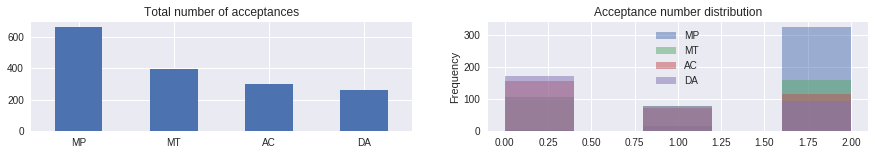

In [3]:
# Read in experimental oberauer data
# It consists of participants' answers to two abstract conditionals
patterns = pd.read_csv('../conditional_data/oberauer_81_patterns.csv')
patterns = patterns.drop(patterns.columns[0], axis=1)

# Transform counts into individual responses
data = []
for pattern in patterns.columns:
    frequency = patterns.loc[0, pattern]
    data += [[int(pattern[i]) for i in range(len(pattern))]] * frequency
data = pd.DataFrame(np.array(data), columns=['MP', 'MT', 'AC', 'DA'])

# Plot data summaries
fig, ax = plt.subplots(1, 2, figsize=(15,2))
data.sum(axis=0).plot(kind='bar', rot=0, ax=ax[0], title='Total number of acceptances')
data.plot(kind='hist', bins=5, alpha=0.5, ax=ax[1], title='Acceptance number distribution')
plt.show()

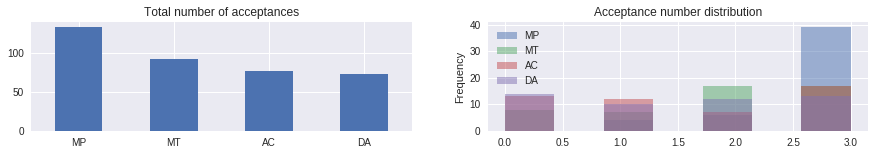

In [4]:
# Read in pre-formatted experimental data from Julia Wertheim's web-experiment
# Data consist of participants' answers to three everyday conditionals with lentils, peas etc.
julia_data = pd.read_csv('data/deduction_individual_responses.csv', sep=',').set_index('token')

#sns.set(style='ticks')
#sns.despine(left=True)
#fig, ax = plt.subplots(2, 1, figsize=(15,8))
fig, ax = plt.subplots(1, 2, figsize=(15,2))
julia_data.sum(axis=0).plot(kind='bar', rot=0, ax=ax[0], title='Total number of acceptances')
julia_data.plot(kind='hist', bins=7, alpha=0.5, ax=ax[1], title='Acceptance number distribution')
plt.show()

In [5]:
modi = np.array(['MP', 'MT', 'AC', 'DA'])
df = pd.DataFrame()
for modus in modi:
    count, division = np.histogram(julia_data[modus], bins=4, range=(0, 3))
    for acceptances in range(len(count)):
        df = df.append(pd.Series([modus, acceptances, count[acceptances]]), ignore_index=True)
df.columns=('Modus', 'Total Acceptances', 'Participant Count')
df[['Total Acceptances', 'Participant Count']] = df[['Total Acceptances', 'Participant Count']].astype(int)

[Text(0,0.5,'Participant Count'), Text(0.5,0,'')]

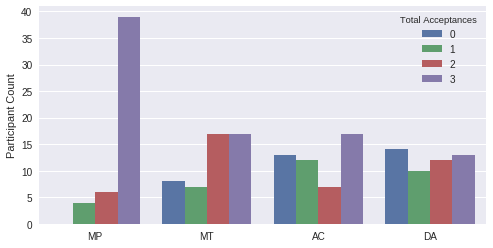

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
sns.set(style='ticks', font_scale=1)
sns.barplot(hue=df['Total Acceptances'], y=df['Participant Count'], x=df['Modus'], ax=ax)
ax.set(ylabel='Participant Count', xlabel='')

### Model imports

In [7]:
from uniform_model import UniformModel
from empirical_aggregate_model import EmpiricalAggregate
from generic_mpt_model import GenericMPT
from chater_oaksford_model import ChaterOaksford
from independence_model import IndependenceModel
from dependence_model import DependenceModel
from adaptive_chater_oaksford_model import AdaptiveChaterOaksford
print('importing done.')

importing done.


## Individualistic Evaluation
* Iterate over all participants
    * For every participant, let every model predict the response
    * Save the score the model archieved
    * Then tell the model the actual resonse
* Evaluate the complete prediction-answer set

In [10]:
THIN = 1



def init_models():
    '''Initialize Baseline Models'''
    models = []
    models = [UniformModel(), GenericMPT(), EmpiricalAggregate()]
    models += [DependenceModel(), IndependenceModel()]
    models += [AdaptiveChaterOaksford(model_name=str(i), weight = i) for i in [0, 1, 2]]
    return models

models = init_models()

modi = data.columns

selected_scoring_rules = {'Quadratic': scoring_rules.quad_score, 
                          'Logarithmic': scoring_rules.mean_log_score,                                                 
                          'Accuracy': scoring_rules.mean_accuracy,
                          'MRR': scoring_rules.mrr_score}


modi = list(data.columns)

datasets = {'julia_webxp': julia_data, 'oberauer': data}

numeric_scores = dict()
for data_name, data_set in datasets.items():
    numeric_scores[data_name] = pd.DataFrame(0.0, columns=['Accuracy', 'MRR', 'Quadratic', 'Logarithmic'], 
                                             index=[model.__name__ for model in models])
    
    print('Dataset: {}, answers: {}'.format(data_name, data_set.max().max()))
    working_data = data_set.copy()

    # Iterate over participants
    for row in range(0, data_set.shape[0], THIN):
        
        # Re-initialize models to remove leftover information
        models = init_models()
        # Fit models to aggregate dataset
        for model in models:
            model.fit(dataset=data_set)

        # Iterate over all four modi MP, MT, AC, DA
        answers = []
        for modus in modi:
            for answer_number in range(0, data_set.max().max()):
                if working_data[modus][row] > 0:
                    answer = (modus, True)
                else:
                    answer = (modus, False)
                answers += [answer]
                
                # remember that this answer is already saved
                working_data[modus][row] -= 1                    
                    
        # Shuffle answers to remove sorting information
        random.shuffle(answers)
        for answer in answers:
            modus = answer[0]
            # Transform answer frequency to [yes, no]
            truth = np.array([[0, 0]])
            if answer[1]:
                truth[0, 0] = 1
            else:
                truth[0, 1] = 1

            # Let all models predict the answer
            for model in models:
                prediction = model.predict(modus)
                # Transform to format [accept, reject]
                prediction = np.array([[prediction, 1 - prediction]])

                # Rate the prediction with all scoring rules
                for rule_name, scoring_rule in selected_scoring_rules.items():
                    numeric_scores[data_name][rule_name][model.__name__] += scoring_rule(np.array(prediction), truth)

                # tell the model what actually happened
                model.feedback(problem=modus, answer=truth[0, 0])

        print('Progress: {} / {}'.format(row, data_set.shape[0]), end='\r')
    print()

    # Divide the scores by the number of participants sampled
    numeric_scores[data_name] /= (data_set.shape[0] / THIN)
    # Divide the scores by the number of answers given per participant (8)
    numeric_scores[data_name] /= (data_set.max().max() * data_set.shape[1])    

Dataset: julia_webxp, answers: 3
Progress: 48 / 49


UniformModel          0.500000
GenericMPT            0.564626
EmpiricalAggregate    0.637755
DependenceModel       0.637755
IndependenceModel     0.627551
0                     0.637755
Name: Accuracy, dtype: float64

Text(0.5,1,'Predictive Performance of Non-Adaptive Models')

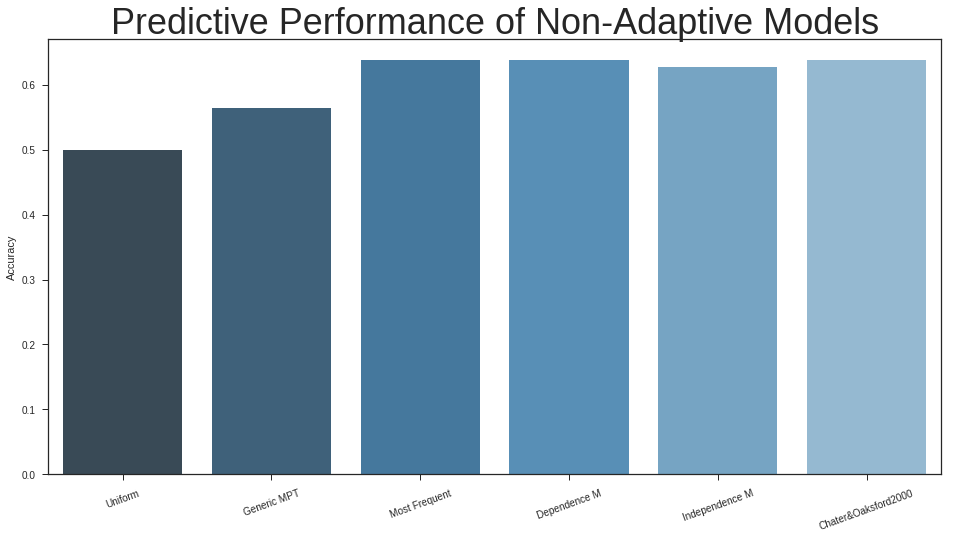

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(16,8))
sns.set(style='ticks', font_scale=3)
df = numeric_scores['julia_webxp']
acc = df.head(6)['Accuracy']
display(acc)
pl = sns.barplot(y=acc, x=acc.index, ax=ax, palette='Blues_d')
#pl.set_xticklabels(pl.get_xticklabels(), rotation=20)
pl.set_xticklabels(['Uniform', 'Generic MPT', 'Most Frequent', 'Dependence M', 'Independence M', 'Chater&Oaksford2000'], rotation=20)
pl.set_ylabel('Accuracy')
pl.set_title('Predictive Performance of Non-Adaptive Models')

UniformModel          0.500000
GenericMPT            0.564626
EmpiricalAggregate    0.637755
DependenceModel       0.637755
IndependenceModel     0.627551
0                     0.637755
1                     0.721088
2                     0.714286
Name: Accuracy, dtype: float64

Text(0.5,1,'Predictive Performance: Non-Adaptive vs Adaptive Models')

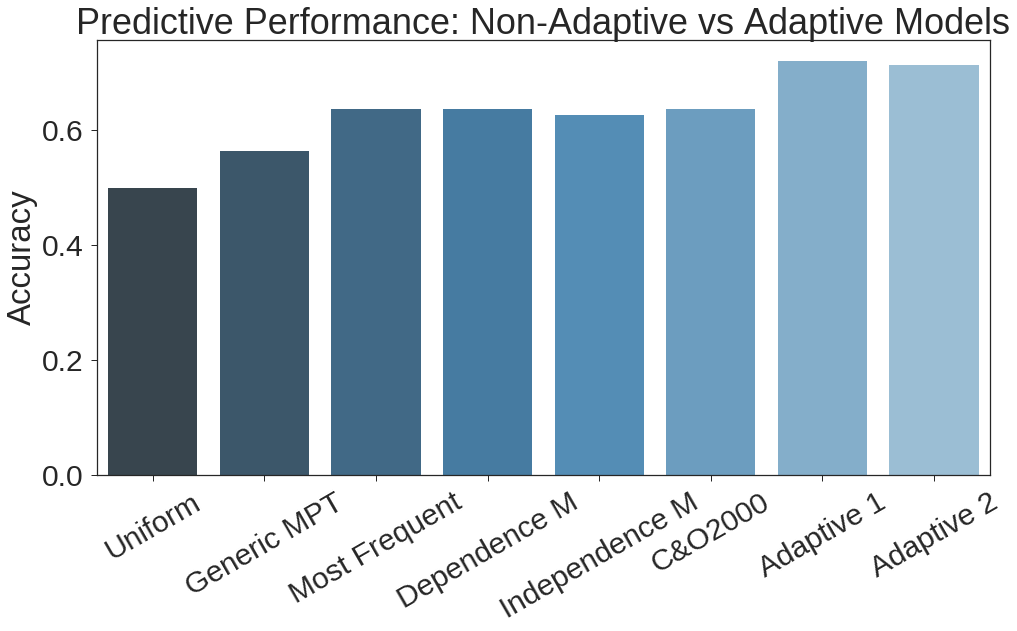

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(16,8))
sns.set(style='ticks', font_scale=3)
df = numeric_scores['julia_webxp']
acc = df['Accuracy']
display(acc)
pl = sns.barplot(y=acc, x=acc.index, ax=ax, palette='Blues_d')
#pl.set_xticklabels(pl.get_xticklabels(), rotation=20)
pl.set_xticklabels(['Uniform', 'Generic MPT', 'Most Frequent', 'Dependence M', 'Independence M', 'C&O2000', 'Adaptive 1', 'Adaptive 2'], rotation=30)
pl.set_ylabel('Accuracy')
pl.set_title('Predictive Performance: Non-Adaptive vs Adaptive Models')

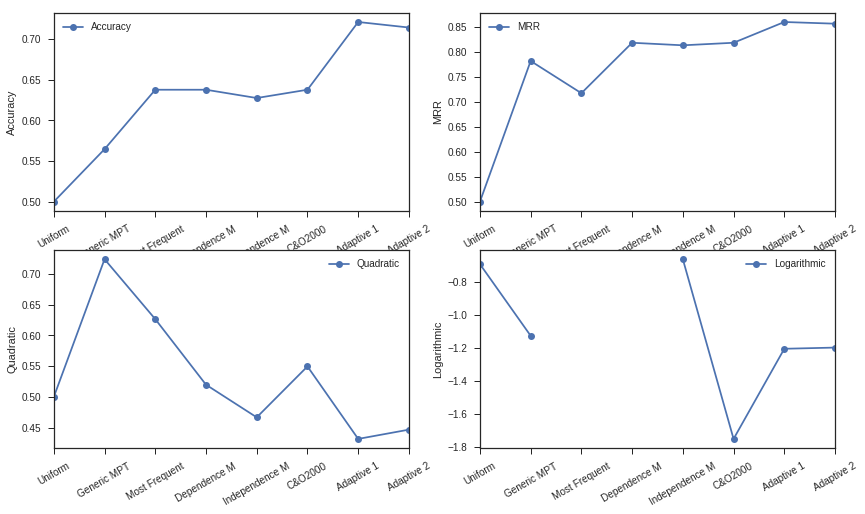

In [30]:
fig, ax = plt.subplots(2, 2, figsize=(14,8))
sns.set(style='ticks', font_scale=1)

legend = []
for data_name, data_set in datasets.items():
    i = 0
    for rule_name in numeric_scores[data_name].columns:
        axis = ax[i // 2, i % 2]
        a = numeric_scores[data_name][rule_name].plot(style='-o', rot=20, ax=axis, legend=True)
        a.set_xticklabels(['Uniform', 'Generic MPT', 'Most Frequent', 'Dependence M', 'Independence M', 'C&O2000', 'Adaptive 1', 'Adaptive 2'], rotation=30)
        
        #axis.set_xlabel('Individual data/Group data')
        axis.set_ylabel(rule_name)
        i += 1
    legend += [data_name]
    
#    i = 0    
#    for rule_name in numeric_scores[data_name].columns:
#        axis = ax[i // 2, i % 2]       
#        axis.legend(legend);
#        i += 1
plt.show() 

### Conclusion
I have done a gridsearch on possible old/new empirical data weighting strategies.
* There seems to be a quasi-optimal value for (*Accuracy, MRR, Quad*) but it is not optimal for *Log*
* This is weird as both Quda and Log are strictly proper scoring rules
* The score-weight landscape is not very smooth, there are spikes